In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

# ==== 프로젝트 루트 경로 ====
ROOT = Path("/Users/gy/projects/trading-project").resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# 본인이 만들어둔 전처리 모듈
from src.preprocess.mt5_xgb_preprocess import load_preprocess_usdjpym20_for_xgb

# ==== 원본 MT5 CSV 경로 ====
csv_path = ROOT / "data_raw" / "usdjpym20_20251117_035207.csv"

# horizon=1: 다음 1캔들 수익률, n_lags=3: 과거 3개 캔들까지 피처로 사용
X, y = load_preprocess_usdjpym20_for_xgb(
    csv_path=str(csv_path),
    n_lags=3,
    horizon=1,
)

print("원래 전체 샘플 수:", len(X))
print("피처 개수:", X.shape[1])
print("시간 구간:", X.index.min(), "→", X.index.max())
print("y (ret_h1) 요약:")
print(y.describe())

# =========================================================
#   BB%b(20, 4) 조건이 걸린 캔들만 남기기
#   - bbpb_20 >= 1
#   - bbpb_20 <= 0
#   - bbpb_4  >= 1
#   - bbpb_4  <= 0
#   중 하나라도 만족하는 현재 봉만 사용
# =========================================================

# 1) 원본 MT5 CSV를 그대로 다시 읽어서 Date+Time → ts index 생성
df_raw = pd.read_csv(csv_path, sep=";")

df_raw["ts"] = pd.to_datetime(df_raw["Date"] + " " + df_raw["Time"])
df_raw = df_raw.set_index("ts").sort_index()

# 2) 현재 봉에서 BB%b(20, 4) 조건 체크
cond_raw = (
    (df_raw["bbpb_20"] >= 1.0)
    | (df_raw["bbpb_20"] <= 0.0)
    | (df_raw["bbpb_4"]  >= 1.0)
    | (df_raw["bbpb_4"]  <= 0.0)
)

# 3) X, y의 index(ts) 기준으로 cond를 재정렬해서 align
#    (lag/horizon 때문에 X.index가 df_raw.index의 부분집합일 수 있으므로 reindex)
cond = cond_raw.reindex(X.index).fillna(False)

# 4) 조건을 만족하는 ts만 선택
X = X.loc[cond].copy()
y = y.loc[cond].copy()

print("\n=== BB%b 조건 필터 후 ===")
print("조건 충족 샘플 수:", cond.sum())
print("조건 충족 비율:", float(cond.mean()))
print("필터 후 X.shape:", X.shape)
print("필터 후 y 요약:")
print(y.describe())


원래 전체 샘플 수: 9355
피처 개수: 64
시간 구간: 2025-05-19 05:00:00 → 2025-11-17 03:20:00
y (ret_h1) 요약:
count    9355.000000
mean        0.000007
std         0.000640
min        -0.011596
25%        -0.000302
50%         0.000007
75%         0.000316
max         0.012389
Name: ret_h1, dtype: float64

=== BB%b 조건 필터 후 ===
조건 충족 샘플 수: 1179
조건 충족 비율: 0.1260288615713522
필터 후 X.shape: (1179, 64)
필터 후 y 요약:
count    1179.000000
mean        0.000013
std         0.000787
min        -0.007282
25%        -0.000367
50%         0.000013
75%         0.000385
max         0.006990
Name: ret_h1, dtype: float64


In [2]:
# ret_h1 > 0 → 1, 아니면 0
y_bin = (y > 0).astype(int)

print("양봉(1) 비율:", y_bin.mean())
print("음봉/제로(0) 비율:", 1 - y_bin.mean())


양봉(1) 비율: 0.5072094995759118
음봉/제로(0) 비율: 0.49279050042408823


In [3]:
n = len(X)
split_idx = int(n * 0.8)  # 앞 80% train, 뒤 20% test

X_train = X.iloc[:split_idx]
y_train = y_bin.iloc[:split_idx]

X_test = X.iloc[split_idx:]
y_test = y_bin.iloc[split_idx:]

print("Train:", X_train.index.min(), "→", X_train.index.max(), "|", X_train.shape)
print("Test :", X_test.index.min(),  "→", X_test.index.max(),  "|", X_test.shape)
print("Train 양봉 비율:", y_train.mean())
print("Test  양봉 비율:", y_test.mean())


Train: 2025-05-19 10:20:00 → 2025-10-10 09:40:00 | (943, 64)
Test : 2025-10-10 17:40:00 → 2025-11-17 02:40:00 | (236, 64)
Train 양봉 비율: 0.5015906680805938
Test  양봉 비율: 0.5296610169491526


In [4]:
# XGBClassifier는 pandas도 받지만, 타입 통일 차원에서 float32로 맞춰줌
X_train_f = X_train.astype(np.float32)
X_test_f  = X_test.astype(np.float32)

# y는 int 0/1이면 충분
y_train_f = y_train.astype(int)
y_test_f  = y_test.astype(int)


/Users/gy/projects/trading-project/.venv/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:133: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
/Users/gy/projects/trading-project/.venv/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:133: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


In [5]:
print("X_train_f shape:", X_train_f.shape)
print("y_train_f shape:", y_train_f.shape)
print("X_test_f shape :", X_test_f.shape)
print("y_test_f shape :", y_test_f.shape)

print("\nNaN 개수 (train):", np.isnan(X_train_f.values).sum())
print("NaN 개수 (test) :", np.isnan(X_test_f.values).sum())

# 혹시 무한대 값이 껴있으면 XGB가 매우 느려지거나 멈출 수 있음
print("\nInf 개수 (train):", np.isinf(X_train_f.values).sum())
print("Inf 개수 (test) :", np.isinf(X_test_f.values).sum())


X_train_f shape: (943, 64)
y_train_f shape: (943,)
X_test_f shape : (236, 64)
y_test_f shape : (236,)

NaN 개수 (train): 0
NaN 개수 (test) : 0

Inf 개수 (train): 30
Inf 개수 (test) : 40


In [6]:
clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    tree_method="hist",   # 안 되면 아래에 'approx'로 바꿔서도 한 번 시도
    eval_metric="logloss",
    n_jobs=1,             # 멀티스레드 이슈 피하기
    random_state=42,
)

# 판다스 → 넘파이 배열로 넘김
Xtr = X_train_f.values
ytr = y_train_f.values
Xte = X_test_f.values
yte = y_test_f.values

print("훈련 시작...")
clf.fit(
    Xtr,
    ytr,
    eval_set=[(Xtr, ytr), (Xte, yte)],
    verbose=True,   # 로그 조금 보이게 해서 진짜 학습 중인지 확인
)
print("훈련 끝!")




훈련 시작...
[0]	validation_0-logloss:0.68716	validation_1-logloss:0.69230
[1]	validation_0-logloss:0.68080	validation_1-logloss:0.69167
[2]	validation_0-logloss:0.67649	validation_1-logloss:0.69115
[3]	validation_0-logloss:0.66901	validation_1-logloss:0.69073
[4]	validation_0-logloss:0.66390	validation_1-logloss:0.69107
[5]	validation_0-logloss:0.65649	validation_1-logloss:0.68973
[6]	validation_0-logloss:0.65145	validation_1-logloss:0.69098
[7]	validation_0-logloss:0.64549	validation_1-logloss:0.69029
[8]	validation_0-logloss:0.64070	validation_1-logloss:0.69012
[9]	validation_0-logloss:0.63652	validation_1-logloss:0.69105
[10]	validation_0-logloss:0.63281	validation_1-logloss:0.69099
[11]	validation_0-logloss:0.62632	validation_1-logloss:0.69162
[12]	validation_0-logloss:0.62075	validation_1-logloss:0.69220
[13]	validation_0-logloss:0.61534	validation_1-logloss:0.69146
[14]	validation_0-logloss:0.61243	validation_1-logloss:0.69262
[15]	validation_0-logloss:0.60614	validation_1-logloss:0

In [7]:
# shape: (n_samples, 2) → [:,0]=p_down, [:,1]=p_up
pred_proba = clf.predict_proba(X_test_f)

p_down = pred_proba[:, 0]
p_up   = pred_proba[:, 1]

proba_df = pd.DataFrame(
    {
        "p_down": p_down,
        "p_up": p_up,
    },
    index=X_test_f.index,
)
print(proba_df.tail())


                       p_down      p_up
ts                                     
2025-11-14 14:20:00  0.785098  0.214902
2025-11-14 14:40:00  0.881294  0.118706
2025-11-14 15:00:00  0.845061  0.154939
2025-11-14 15:20:00  0.809730  0.190270
2025-11-17 02:40:00  0.795087  0.204913


In [8]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 기본 threshold 0.5 기준 예측 레이블
y_pred_label = (p_up >= 0.5).astype(int)

acc = accuracy_score(y_test_f, y_pred_label)
auc = roc_auc_score(y_test_f, p_up)  # positive class(양봉) 확률로 AUC

print(f"Test Accuracy (threshold=0.5): {acc:.4f}")
print(f"Test AUC (양봉=1 기준):         {auc:.4f}")


Test Accuracy (threshold=0.5): 0.6229
Test AUC (양봉=1 기준):         0.6339


In [9]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test_f, y_pred_label)
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test_f, y_pred_label, digits=4))


Confusion Matrix (rows=true, cols=pred):
[[68 43]
 [46 79]]

Classification Report:
              precision    recall  f1-score   support

           0     0.5965    0.6126    0.6044       111
           1     0.6475    0.6320    0.6397       125

    accuracy                         0.6229       236
   macro avg     0.6220    0.6223    0.6221       236
weighted avg     0.6235    0.6229    0.6231       236



In [10]:
# 컬럼 다 보이게
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.expand_frame_repr", False)

result_df = pd.DataFrame(
    {
        "ret_h1": y.iloc[split_idx:],      # 원래 연속 수익률
        "dir_true": y_test_f,              # 0/1 실제 방향
        "p_down": p_down,
        "p_up": p_up,
        "sig_long_55": (p_up >= 0.55).astype(int),
        "sig_short_55": (p_down >= 0.55).astype(int),
    },
    index=X_test_f.index,
)

print(result_df.tail())


                       ret_h1  dir_true    p_down      p_up  sig_long_55  sig_short_55
ts                                                                                    
2025-11-14 14:20:00 -0.001953         0  0.785098  0.214902            0             1
2025-11-14 14:40:00 -0.000364         0  0.881294  0.118706            0             1
2025-11-14 15:00:00 -0.000228         0  0.845061  0.154939            0             1
2025-11-14 15:20:00  0.002394         1  0.809730  0.190270            0             1
2025-11-17 02:40:00 -0.000207         0  0.795087  0.204913            0             1


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ===== 경로 설정 (본인 프로젝트 루트에 맞게) =====
ROOT = Path("/Users/gy/projects/trading-project").resolve()
csv_path = ROOT / "data_raw" / "usdjpym20_20251117_035207.csv"   # 파일명만 맞게 수정

# ===== MT5 CSV 로드 =====
df = pd.read_csv(csv_path, sep=";")

# Date + Time → datetime index
df["ts"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df = df.set_index("ts").sort_index()

print(df.columns)   # 한 번 확인해보고 밑에서 쓸 컬럼명 맞춰줘


Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVolume', 'bbpb_20', 'bbpb_4', 'bbw_20', 'bbw_4', 'dp_14', 'Signal', 'Buy', 'Sell', 'OAN', 'XMG', 'Average'], dtype='object')


In [12]:
# ===== 볼린저 %b 조건 (이벤트 시점) =====
cond_bb = (
    (df["bbpb_20"] >= 1.0) |
    (df["bbpb_20"] <= 0.0) |
    (df["bbpb_4"]  >= 1.0) |
    (df["bbpb_4"]  <= 0.0)
)

df_event = df.loc[cond_bb].copy()

print("전체 바 개수:", len(df))
print("BB%b 이벤트 개수:", len(df_event))
print("비율:", cond_bb.mean())


전체 바 개수: 9359
BB%b 이벤트 개수: 1179
비율: 0.12597499732877443


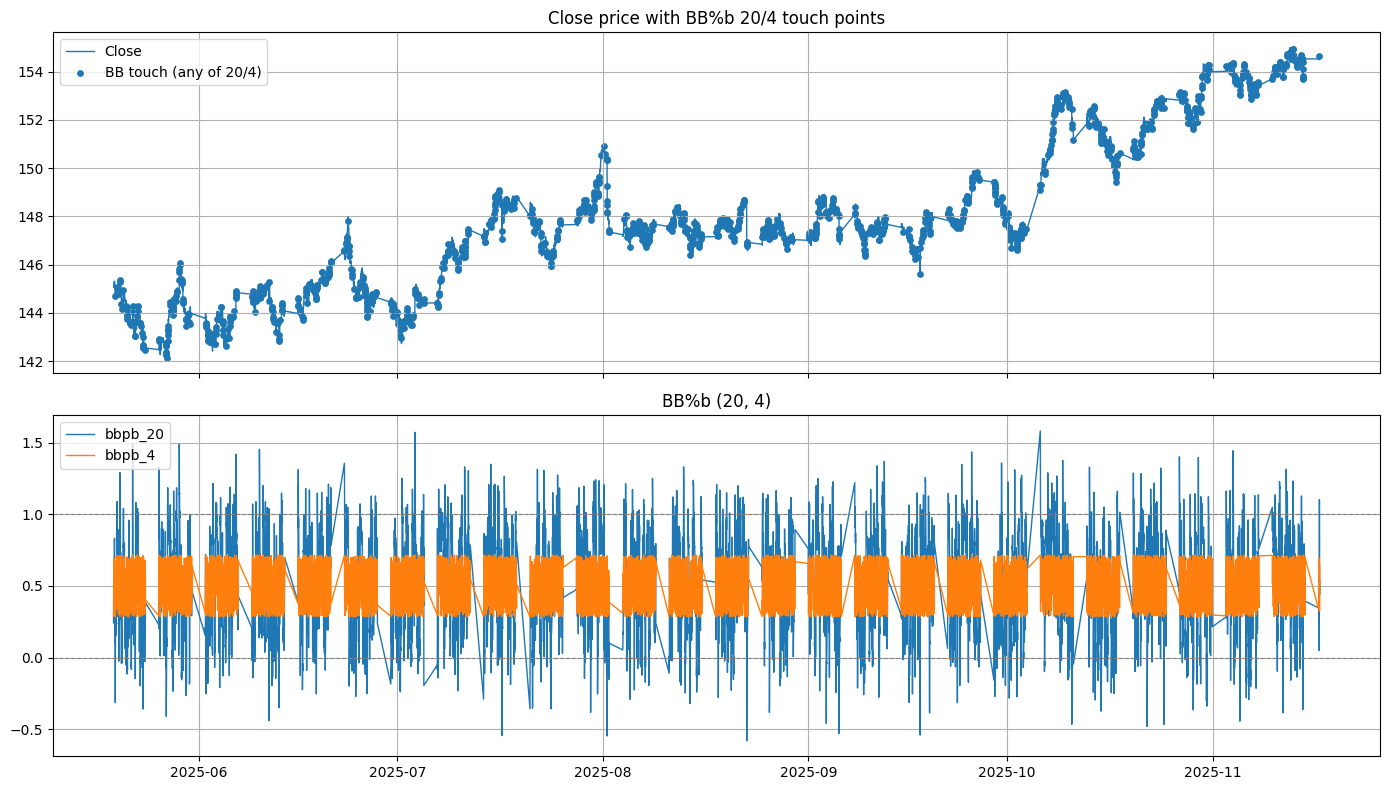

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# (1) 종가 + 터치 시점 표시
axes[0].plot(df.index, df["Close"], label="Close", linewidth=1)
axes[0].scatter(
    df_event.index,
    df_event["Close"],
    s=15,
    marker="o",
    label="BB touch (any of 20/4)",
)
axes[0].set_title("Close price with BB%b 20/4 touch points")
axes[0].legend(loc="upper left")
axes[0].grid(True)

# (2) BB%b 20/4 시계열 + 기준선
axes[1].plot(df.index, df["bbpb_20"], label="bbpb_20", linewidth=1)
axes[1].plot(df.index, df["bbpb_4"],  label="bbpb_4",  linewidth=1)

axes[1].axhline(1.0, color="gray", linestyle="--", linewidth=0.8)
axes[1].axhline(0.0, color="gray", linestyle="--", linewidth=0.8)
axes[1].set_title("BB%b (20, 4)")
axes[1].legend(loc="upper left")
axes[1].grid(True)

plt.tight_layout()
plt.show()


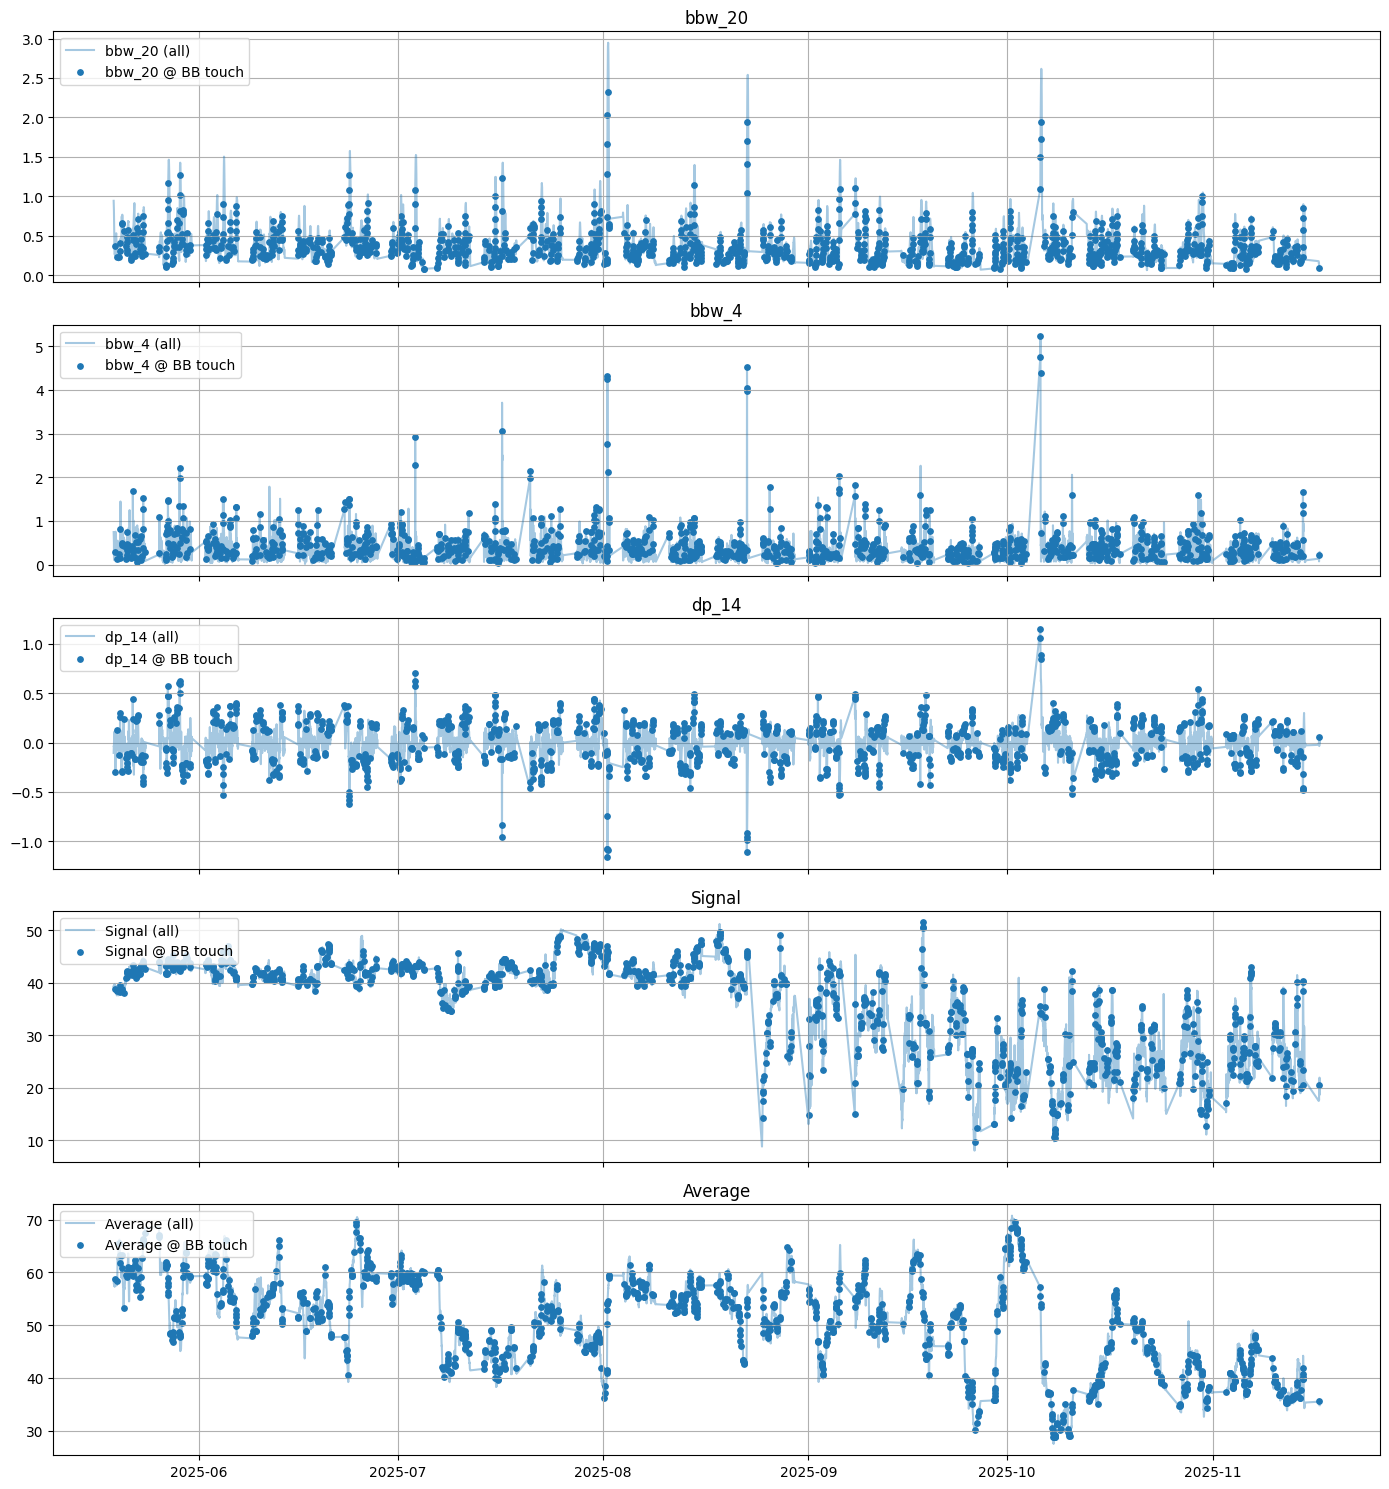

In [14]:
# 보고 싶은 피처들 (컬럼명은 df.columns 보고 맞춰서 수정)
cols_features = [
    "bbw_20",
    "bbw_4",
    "dp_14",
    "Signal",
    "Average",
    # 필요하면 추가
    # "ret_h1", ...
]

fig, axes = plt.subplots(len(cols_features), 1,
                         figsize=(14, 3 * len(cols_features)),
                         sharex=True)

if len(cols_features) == 1:
    axes = [axes]  # 한 개일 때도 for문 돌리기 편하게

for col, ax in zip(cols_features, axes):
    # 전체 시계열 (옅게)
    ax.plot(df.index, df[col], label=f"{col} (all)", alpha=0.4)
    # BB 터치 시점 값 (점으로 강조)
    ax.scatter(df_event.index, df_event[col],
               s=15,
               marker="o",
               label=f"{col} @ BB touch")
    ax.set_title(col)
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()


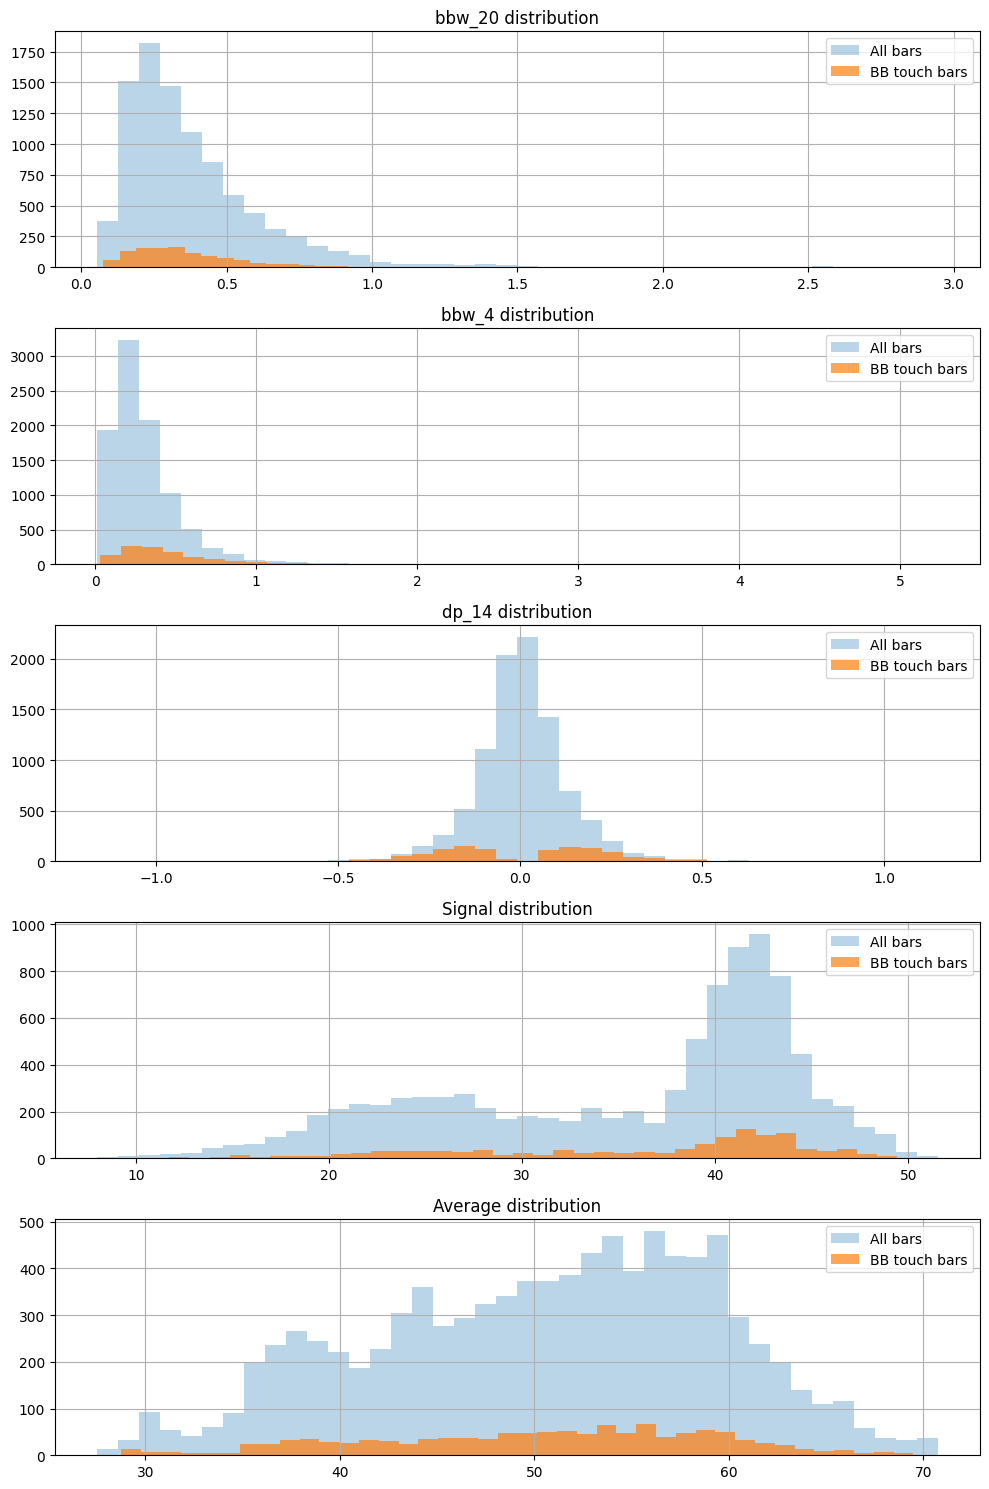

In [15]:
fig, axes = plt.subplots(len(cols_features), 1,
                         figsize=(10, 3 * len(cols_features)))

if len(cols_features) == 1:
    axes = [axes]

for col, ax in zip(cols_features, axes):
    all_vals = df[col].dropna()
    evt_vals = df_event[col].dropna()

    ax.hist(all_vals, bins=40, alpha=0.3, label="All bars")
    ax.hist(evt_vals, bins=40, alpha=0.7, label="BB touch bars")

    ax.set_title(f"{col} distribution")
    ax.legend(loc="upper right")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [16]:
import numpy as np

# 다음 1캔들 수익률 (종가 기준, 원하면 차이로 바꿔도 됨)
df["ret_h1"] = df["Close"].pct_change().shift(-1)

# 다음봉 방향 라벨: 상승 / 하락(또는 제로)
df["dir_h1"] = np.where(df["ret_h1"] > 0, "up", "down_or_flat")

df[["Close", "ret_h1", "dir_h1"]].tail()


,Close,ret_h1,dir_h1
ts,,,
2025-11-17 02:20:00,154.572,0.000356,up
2025-11-17 02:40:00,154.627,-0.000207,down_or_flat
2025-11-17 03:00:00,154.595,-0.000382,down_or_flat
2025-11-17 03:20:00,154.536,0.000084,up
2025-11-17 03:40:00,154.549,NaN,down_or_flat


In [17]:
# ===== 상단 터치 (20) =====
cond_up_20 = df["bbpb_20"] >= 1.0

df_up_20_up   = df[cond_up_20 & (df["dir_h1"] == "up")]            # 20 상단 터치 + 다음봉 상승
df_up_20_down = df[cond_up_20 & (df["dir_h1"] == "down_or_flat")]  # 20 상단 터치 + 다음봉 하락/제로

print("bbpb_20 >= 1.0 (상단 터치)")
print(" - 다음봉 상승:", len(df_up_20_up))
print(" - 다음봉 하락/제로:", len(df_up_20_down))


# ===== 상단 터치 (4) =====
cond_up_4 = df["bbpb_4"] >= 1.0

df_up_4_up   = df[cond_up_4 & (df["dir_h1"] == "up")]            # 4 상단 터치 + 다음봉 상승
df_up_4_down = df[cond_up_4 & (df["dir_h1"] == "down_or_flat")]  # 4 상단 터치 + 다음봉 하락/제로

print("\nbbpb_4 >= 1.0 (상단 터치)")
print(" - 다음봉 상승:", len(df_up_4_up))
print(" - 다음봉 하락/제로:", len(df_up_4_down))


bbpb_20 >= 1.0 (상단 터치)
 - 다음봉 상승: 296
 - 다음봉 하락/제로: 289

bbpb_4 >= 1.0 (상단 터치)
 - 다음봉 상승: 0
 - 다음봉 하락/제로: 0


In [18]:
# ===== 하단 터치 (20) =====
cond_dn_20 = df["bbpb_20"] <= 0.0

df_dn_20_up   = df[cond_dn_20 & (df["dir_h1"] == "up")]            # 20 하단 터치 + 다음봉 상승
df_dn_20_down = df[cond_dn_20 & (df["dir_h1"] == "down_or_flat")]  # 20 하단 터치 + 다음봉 하락/제로

print("bbpb_20 <= 0.0 (하단 터치)")
print(" - 다음봉 상승:", len(df_dn_20_up))
print(" - 다음봉 하락/제로:", len(df_dn_20_down))


# ===== 하단 터치 (4) =====
cond_dn_4 = df["bbpb_4"] <= 0.0

df_dn_4_up   = df[cond_dn_4 & (df["dir_h1"] == "up")]            # 4 하단 터치 + 다음봉 상승
df_dn_4_down = df[cond_dn_4 & (df["dir_h1"] == "down_or_flat")]  # 4 하단 터치 + 다음봉 하락/제로

print("\nbbpb_4 <= 0.0 (하단 터치)")
print(" - 다음봉 상승:", len(df_dn_4_up))
print(" - 다음봉 하락/제로:", len(df_dn_4_down))


bbpb_20 <= 0.0 (하단 터치)
 - 다음봉 상승: 302
 - 다음봉 하락/제로: 292

bbpb_4 <= 0.0 (하단 터치)
 - 다음봉 상승: 0
 - 다음봉 하락/제로: 0
